# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well..


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Labels.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

### **Note: Please use GPU runtime on Google Colab to execute the code faster.**

## Importing necessary libraries

In [45]:
# Installing the libraries with the specified version.
# uncomment and run the following line if Google Colab is being used
# !pip install tensorflow==2.15.0 scikit-learn==1.2.2 seaborn==0.13.1 matplotlib==3.7.1 numpy==1.25.2 pandas==1.5.3 opencv-python==4.8.0.76 -q --user

In [46]:
# Installing the libraries with the specified version.
# uncomment and run the following lines if Jupyter Notebook is being used
#!pip install tensorflow==2.13.0 scikit-learn==1.2.2 seaborn==0.11.1 matplotlib==3.3.4 numpy==1.24.3 pandas==1.5.2 opencv-python==4.8.0.76 -q --user

**Note**: *After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.*

In [47]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
#from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [48]:
# Uncomment and run the below code if you are using google colab
# from google.colab import drive
# drive.mount('/content/drive')

In [49]:
# Load the image file of the dataset
images = np.load('images.npy') #Compressed version of images

# Load the labels file of the dataset
labels = pd.read_csv('Labels.csv') #Contains the labels of images in NPY

## Data Overview

### Understand the shape of the dataset

In [50]:
print(images.shape)         # Print Images Shape
print(labels.shape)         # Print Label Shape

(4750, 128, 128, 3)
(4750, 1)


Observation - We need to build 12 class classifer with 4750 data points.

## Exploratory Data Analysis

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

In [51]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

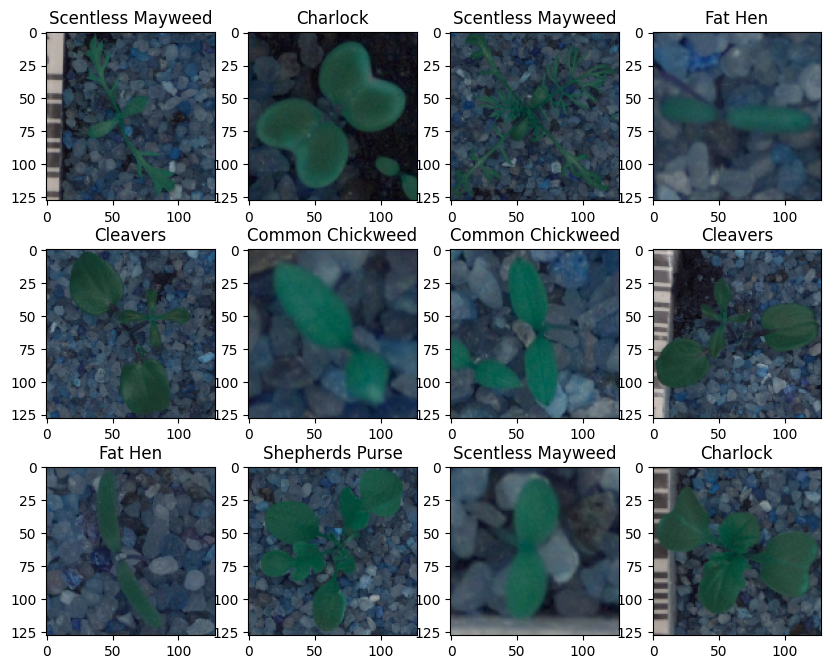

In [52]:
plot_images(images,labels) # Plotting Random Images...

## Checking for Data Imbalance

(array([  0., 100., 200., 300., 400., 500., 600., 700.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500'),
  Text(600.0, 0, '600'),
  Text(700.0, 0, '700')])

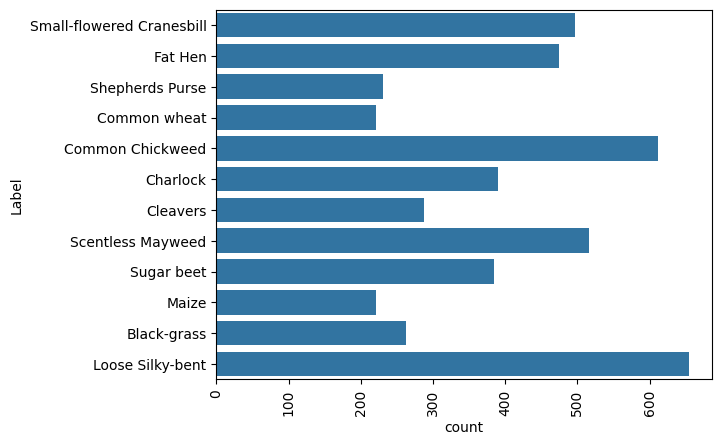

In [53]:
sns.countplot(labels['Label'])
plt.xticks(rotation='vertical')

Observation: Data set is pretty imbalanced. Loose silky-bent we have 600+ data points, where as Purse, sheat, cleavers, maize are less than 300. There are high amount of variation.

## Data Pre-Processing

### Convert the BGR images to RGB images.

In [54]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

### Resize the images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [55]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

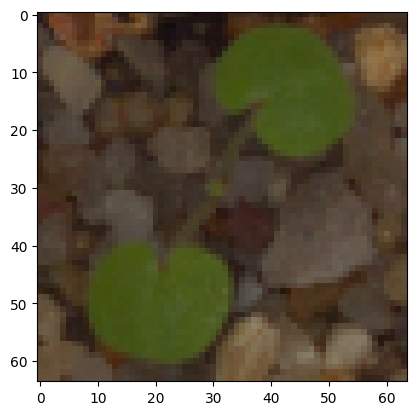

In [56]:
plt.imshow(images_decreased[5])

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [57]:
#We will use 10% of data for test, 10% for validation and remaining 80% for testing...

from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [58]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3847, 64, 64, 3) (3847, 1)
(428, 64, 64, 3) (428, 1)
(475, 64, 64, 3) (475, 1)


### Encode the target labels

In [59]:
# Convert labels from names to one hot vectors.
# We will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train) ##Learn & transform the data...
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)



In [60]:
y_train_encoded

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

### Data Normalization

In [61]:
# Normalizing the image pixels. To get pixel value between 0 & 1
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


## Model Building

## Model Building - Convolutional Neural Network (CNN)

In [62]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

In [63]:
# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [64]:
# Intializing a sequential model
model = Sequential()

#Group 1
# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))

#Group 2
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 10 neurons and activation functions as softmax since this is a multi-class classification problem

#Group 3
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 16)                1

In [65]:
print(X_train_normalized.shape)
print(y_train_encoded.shape)
print(X_val_normalized.shape)
print(y_val_encoded.shape)

(3847, 64, 64, 3)
(3847, 12)
(428, 64, 64, 3)
(428, 12)


## Fitting the model on trained data

In [66]:
history_1 = model.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=32,
            verbose=2
)

Epoch 1/30
121/121 - 3s - loss: 2.4529 - accuracy: 0.1269 - val_loss: 2.3865 - val_accuracy: 0.1449 - 3s/epoch - 28ms/step
Epoch 2/30
121/121 - 3s - loss: 2.2954 - accuracy: 0.1840 - val_loss: 2.1333 - val_accuracy: 0.2477 - 3s/epoch - 26ms/step
Epoch 3/30
121/121 - 3s - loss: 2.0974 - accuracy: 0.2480 - val_loss: 1.9520 - val_accuracy: 0.3388 - 3s/epoch - 27ms/step
Epoch 4/30
121/121 - 3s - loss: 1.9900 - accuracy: 0.2924 - val_loss: 1.8090 - val_accuracy: 0.3598 - 3s/epoch - 25ms/step
Epoch 5/30
121/121 - 3s - loss: 1.9261 - accuracy: 0.3143 - val_loss: 1.7384 - val_accuracy: 0.3808 - 3s/epoch - 24ms/step
Epoch 6/30
121/121 - 3s - loss: 1.8738 - accuracy: 0.3187 - val_loss: 1.7046 - val_accuracy: 0.3855 - 3s/epoch - 24ms/step
Epoch 7/30
121/121 - 3s - loss: 1.8618 - accuracy: 0.3182 - val_loss: 1.6627 - val_accuracy: 0.4019 - 3s/epoch - 24ms/step
Epoch 8/30
121/121 - 3s - loss: 1.8266 - accuracy: 0.3288 - val_loss: 1.6309 - val_accuracy: 0.4089 - 3s/epoch - 24ms/step
Epoch 9/30
121/1

Observation: Training accuracy is .55 and validation accuracy is .59. The model seems to be correctly fitting. not lot of descrepenacy between training and validation acuracy.

## Model Evaluation

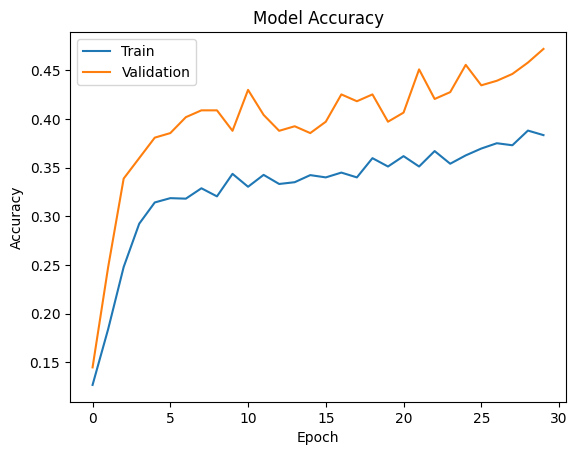

In [67]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observation: Decent amount of accuracy with Training & Validation. We can also see the accuracy of both has started dropping towards the end.

## Evaluating model on test data

In [68]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.5272 - accuracy: 0.4716 - 134ms/epoch - 9ms/step


## Generating Predictions using Test Data

In [69]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 9ms/step


In [70]:
y_pred


array([[3.2405321e-11, 1.2007483e-01, 6.8950298e-04, ..., 9.3431205e-02,
        5.6918338e-02, 2.9230656e-02],
       [1.2432010e-06, 5.3719305e-02, 2.9909849e-02, ..., 6.1477419e-02,
        6.9598347e-01, 6.2775292e-02],
       [1.9566252e-05, 2.4628649e-02, 5.2100491e-02, ..., 3.0862696e-02,
        7.5506067e-01, 4.4514712e-02],
       ...,
       [2.8148612e-01, 1.4583870e-07, 3.9870694e-04, ..., 6.8212138e-09,
        7.4407134e-09, 7.4174587e-04],
       [1.0138857e-03, 1.5544344e-01, 5.8150548e-02, ..., 8.9409277e-02,
        6.6927619e-02, 8.2854249e-02],
       [1.5261190e-04, 1.0328139e-01, 8.6851500e-02, ..., 8.9825608e-02,
        4.1337642e-01, 1.0232245e-01]], dtype=float32)

## Plotting Confusion Matrix

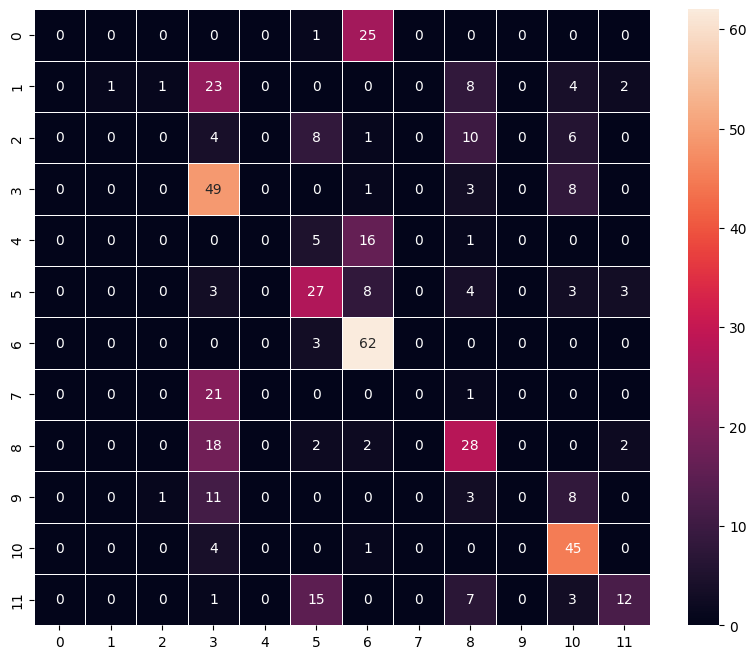

In [71]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation - 

## Data Augmentation

#Remember, **data augmentation should not be used in the validation/test data set**.

In [72]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [73]:
# All images to be rescaled by 1/255. Using only 1 augumentation, which is rotation range - 20
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [74]:
# Intializing a sequential model
model = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model.add(MaxPooling2D((2, 2), padding = 'same'))
# model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding = 'same'))
model.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem
model.add(Dense(12, activation='softmax'))

# Using SGD Optimizer
# opt = SGD(learning_rate=0.01, momentum=0.9)
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [75]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history = model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 4s 56ms/step - loss: 2.1299 - accuracy: 0.2490 - val_loss: 2.3976 - val_accuracy: 0.1682
Epoch 2/25
60/60 [==============================] - 3s 49ms/step - loss: 1.7207 - accuracy: 0.3992 - val_loss: 2.3061 - val_accuracy: 0.1636
Epoch 3/25
60/60 [==============================] - 3s 48ms/step - loss: 1.5169 - accuracy: 0.4589 - val_loss: 2.2148 - val_accuracy: 0.3154
Epoch 4/25
60/60 [==============================] - 3s 53ms/step - loss: 1.4131 - accuracy: 0.5170 - val_loss: 2.0683 - val_accuracy: 0.3411
Epoch 5/25
60/60 [==============================] - 3s 49ms/step - loss: 1.3314 - accuracy: 0.5342 - val_loss: 1.9313 - val_accuracy: 0.3294
Epoch 6/25
60/60 [==============================] - 3s 50ms/step - loss: 1.2162 - accuracy: 0.5707 - val_loss: 1.8311 - val_accuracy: 0.3621
Epoch 7/25
60/60 [==============================] - 3s 49ms/step - loss: 1.1726 - accuracy: 0.5876 - val_loss: 1.4566 - val_accuracy: 0.5911
Epoch 8/25
60

Observation: The difference between accuracy and val accuracy is increasing and model is probably overfitting

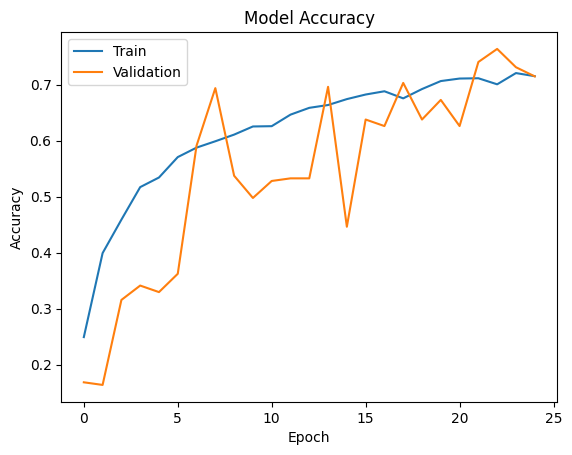

In [76]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Obervations:
1. Increasing Training Accuracy: As the number of epochs increases, the training accuracy generally improves. This is expected as the model learns more from the training data.

2. Overfitting Potential: While the training accuracy continues to rise, the validation accuracy fluctuates and may eventually plateau or even start to decline. This indicates a potential for overfitting, where the model becomes too specialized to the training data and struggles to generalize to new, unseen data.

In [77]:
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 0s - loss: 1.0466 - accuracy: 0.7179 - 137ms/epoch - 9ms/step


Observation: Accuracy has not increased much compared to previous model.

In [78]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

15/15 [==============================] - 0s 8ms/step


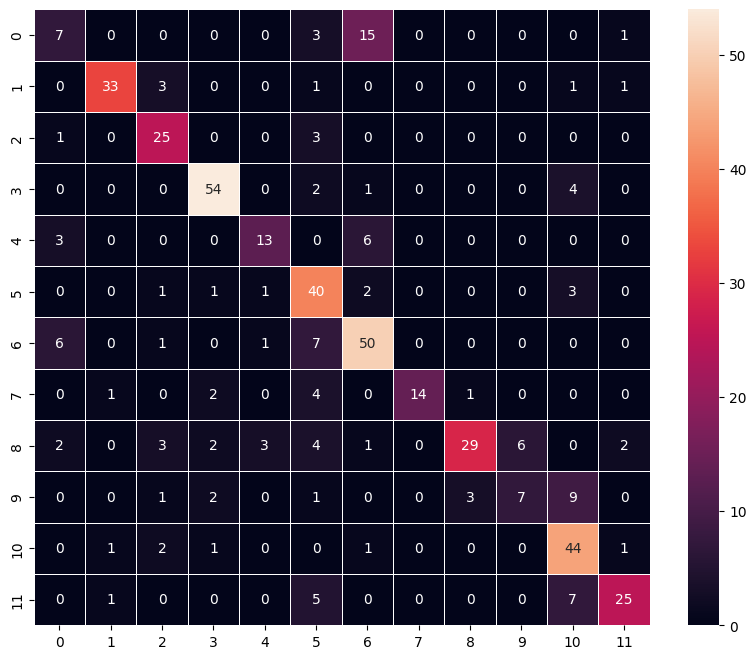

In [79]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

# Transfer Learning using VGG16

In [80]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [81]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [82]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(32, activation='relu'))
new_model.add(Dropout(0.2))
new_model.add(Dense(16, activation='relu'))
new_model.add(Dense(12, activation='softmax'))
opt=Adam()
# Compile model
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 32)                65568     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 12)                204       
                                                                 
Total params: 14780988 (56.38 MB)
Trainable params: 66

In [83]:
# Epochs
epochs = 25
# Batch size
batch_size = 64

history_vgg16 = new_model.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=batch_size,
                                       seed=42,
                                       shuffle=False),
                    epochs=epochs,
                    steps_per_epoch=X_train_normalized.shape[0] // batch_size,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/25
60/60 [==============================] - 18s 290ms/step - loss: 2.3819 - accuracy: 0.1644 - val_loss: 2.2586 - val_accuracy: 0.2827
Epoch 2/25
60/60 [==============================] - 17s 287ms/step - loss: 2.1709 - accuracy: 0.2712 - val_loss: 2.0446 - val_accuracy: 0.3762
Epoch 3/25
60/60 [==============================] - 17s 282ms/step - loss: 1.9579 - accuracy: 0.3431 - val_loss: 1.8623 - val_accuracy: 0.3668
Epoch 4/25
60/60 [==============================] - 17s 282ms/step - loss: 1.7986 - accuracy: 0.3777 - val_loss: 1.7707 - val_accuracy: 0.3879
Epoch 5/25
60/60 [==============================] - 17s 283ms/step - loss: 1.7047 - accuracy: 0.3984 - val_loss: 1.6618 - val_accuracy: 0.3972
Epoch 6/25
60/60 [==============================] - 17s 286ms/step - loss: 1.6284 - accuracy: 0.4272 - val_loss: 1.6107 - val_accuracy: 0.4439
Epoch 7/25
60/60 [==============================] - 17s 285ms/step - loss: 1.5909 - accuracy: 0.4330 - val_loss: 1.5527 - val_accuracy: 0.4556

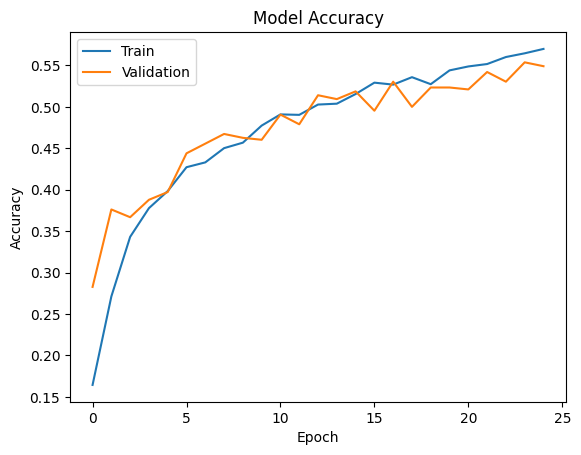

In [84]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [85]:
accuracy = new_model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

15/15 - 2s - loss: 1.2983 - accuracy: 0.5642 - 2s/epoch - 136ms/step


In [86]:
# Here we would get the output as probablities for each category
y_pred=new_model.predict(X_test_normalized)

15/15 [==============================] - 2s 146ms/step


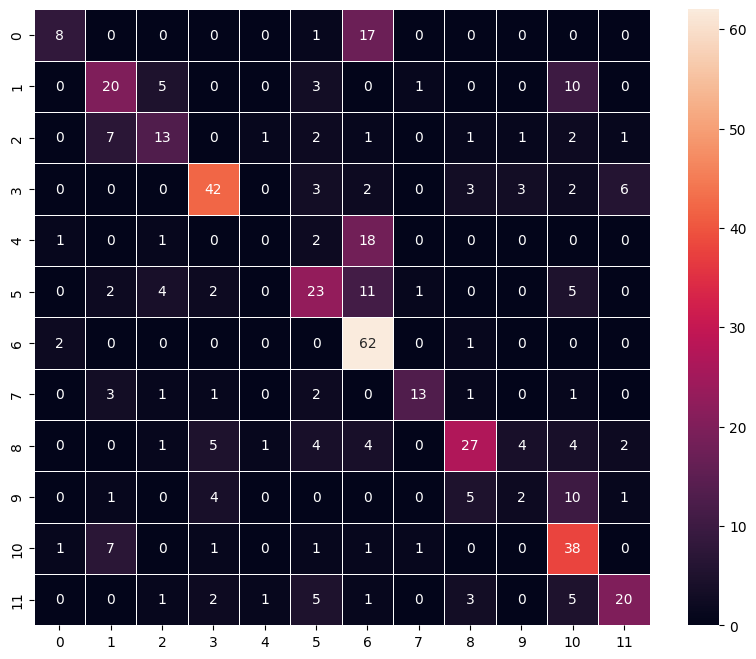

In [87]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Obersevation - We are seeing that #9 is almost accurate. Not an ideal model

## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

## Final Model

In [88]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model'],'Train Accuracy':['64%','70%','77%'],'Validation Accuracy':['48%','53%','63%'],'Test Accuracy':['51%','62%','63%']})

,Models,Train Accuracy,Validation Accuracy,Test Accuracy
0,Base CNN Model,64%,48%,51%
1,CNN Model with Data Augmentation,70%,53%,62%
2,Transfer Learning Model,77%,63%,63%


Observation: The best model seem to be the one with Transfer learning. It has a high test accuracy compared to other modl.s

### Visualizing the prediction

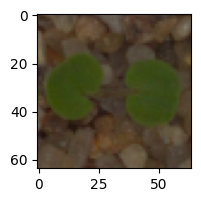

1/1 [==============================] - 0s 22ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


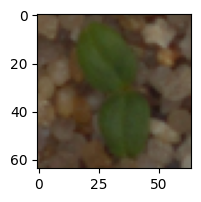

1/1 [==============================] - 0s 24ms/step
Predicted Label ['Fat Hen']
True Label Cleavers


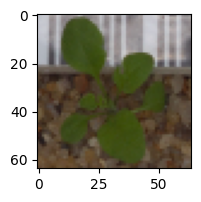

1/1 [==============================] - 0s 23ms/step
Predicted Label ['Charlock']
True Label Shepherds Purse


In [89]:
# Visualizing the predicted and correct label of images from test data
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', enc.inverse_transform(new_model.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', enc.inverse_transform(y_test_encoded)[36])                                              # using inverse_transform() to get the output label from the output vector

* We can see that by simply employing transfer learning accuracy can be improved significantly
* We can improve further accuracy by getting more data and improved resolution
* Training and doing the training on higher resolution. We reduced the images to 64x64
* More data augumentation methods can be followed
* We can try with different epocs or filters and see if it improves the accuracy


_____